In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import qgrid
import pandas_profiling
import csv # Savng CSV file
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline



In [3]:
# Reading tables of interests
file = "/Users/nazlirafei/Library/CloudStorage/"

df_abilities = pd.read_excel(file + "db_26_2_excel/Abilities.xlsx")
df_skills = pd.read_excel(file + "db_26_2_excel/Skills.xlsx")
df_WorkAct = pd.read_excel(file + "db_26_2_excel/Work Activities.xlsx")
df_Interests = pd.read_excel(file + "db_26_2_excel/Interests.xlsx")
df_Workstyle = pd.read_excel(file + "db_26_2_excel/Work Styles.xlsx")


df_occupations = pd.read_excel(file + "db_26_2_excel/Occupation Data.xlsx")
print("Done")

Done


Going through the tables of interest, we need to filter for "LV" ,a nd in table of Workstyle which we don't have "LV" we chose "IM" as scale ID. Then columns of interests are chosen and for the reason explained in pdf in labeling section, first four characters of Element ID are cosen for all datasets, then we group by 'O*NET-SOC Code','Title','Element ID' columns and aggregate the data value with mean. Then I droped NA in rows with all NA, make a pivot table to have Element Ids as columns and data values as row. And finally merged all tables from our four different tables of interests.

In [ ]:
df = [df_abilities, df_skills, df_WorkAct, df_Workstyle]

In [ ]:

# Selecting "Element Names" which describe Analytical occupation
selected_elements=['O*NET-SOC Code','Title','1.A.1.b','1.C.7.a','1.C.7.b','2.A.2.a','2.A.2.b','2.B.2.i','4.A.2.a','4.A.2.b'] 

# filter go scale ID for differnet tables, those which has "LV",
# "LV" was chosen and for others either "IM" 
for i in range(0,4):
    if i == 3:
        df[i] = df[i][df[i]['Scale ID'] == 'IM']
    else: 
        df[i] = df[i][df[i]['Scale ID'] == 'LV']
    #Picking columns of interests
    df[i] = df[i][["O*NET-SOC Code", "Title", "Element ID", "Data Value"]]

    #Taking out just first four digits of element ID of all these data.
    df[i]['Element ID'] = df[i]['Element ID'].map(lambda x:x[:7])

    # Group by 'O*NET-SOC Code','Title','Element ID', to get the mean of values for Data Value for each observation
    df[i] = df[i].groupby(['O*NET-SOC Code','Title','Element ID']).agg({'Data Value': 'mean'}).reset_index().rename(columns={'Data Value':'Avg Data Value'})
    
    #Round number for Avg Data Value to two decimal
    df[i]['Avg Data Value']=df[i]['Avg Data Value'].apply(lambda x: round(x, 2))

    # MAke Pivot table to have data value for each element
    df[i]=df[i].pivot_table(index=['O*NET-SOC Code', "Title"],columns='Element ID',values='Avg Data Value').reset_index()
    if i == 2:
        #df_WorkAct had just one column and so I could use drop NA
        df[i] = df[i][df[i].columns.intersection(selected_elements)].dropna()
    else: 
        # Drop rows having only missing values
        df[i] = df[i][df[i].columns.intersection(selected_elements)].dropna(how='all')


df_merged=df[0].merge(df[1],on=("O*NET-SOC Code","Title"),how='left'
                            ).merge(df[2],on=("O*NET-SOC Code","Title"),how='left'
                                   ).merge(df[3],on=("O*NET-SOC Code","Title"),how='left').reset_index(drop=True)

In [ ]:
df_temp = pd.DataFrame(df_merged, columns=['O*NET-SOC Code', 'Title', '1.A.1.b', '2.A.2.a', '2.A.2.b', '2.B.2.i',
       '4.A.2.a', '4.A.2.b', '1.C.7.a', '1.C.7.b'])
df_temp

,O*NET-SOC Code,Title,1.A.1.b,2.A.2.a,2.A.2.b,2.B.2.i,4.A.2.a,4.A.2.b,1.C.7.a,1.C.7.b
0,11-1011.00,Chief Executives,4.57,4.75,4.75,5.00,5.37,5.28,4.27,4.45
1,11-1011.03,Chief Sustainability Officers,4.05,4.12,3.88,4.12,4.58,5.43,4.48,4.52
2,11-1021.00,General and Operations Managers,3.47,4.00,3.62,3.75,4.07,4.32,3.65,4.03
3,11-2011.00,Advertising and Promotions Managers,4.00,4.12,4.12,3.88,3.47,4.49,3.99,3.88
4,11-2021.00,Marketing Managers,3.93,4.25,4.12,3.88,3.51,4.65,4.15,4.00
...,...,...,...,...,...,...,...,...,...,...
868,53-7071.00,Gas Compressor and Gas Pumping Station Operators,2.86,3.00,2.38,3.00,4.30,3.91,3.44,4.09
869,53-7072.00,"Pump Operators, Except Wellhead Pumpers",2.80,3.12,2.88,2.88,3.94,4.18,2.46,3.09
870,53-7073.00,Wellhead Pumpers,2.70,3.00,2.12,2.88,3.74,3.60,3.49,3.71
871,53-7081.00,Refuse and Recyclable Material Collectors,2.30,3.00,2.00,2.12,2.17,2.52,3.56,3.37


In [ ]:
#Replacing element IDs with Element names in order to make it easier to read and underestand
df_temp.rename(columns = {'1.A.1.b' : 'Idea Generation and Reasoning Abilities', '1.C.7.a' : 'Innovation',
 '1.C.7.b' : 'Analytical Thinking' , '2.A.2.a' : 'Critical Thinking', '2.A.2.b' : 'Active Learning',
  '2.B.2.i' : 'Complex Problem Solving', '4.A.2.a' : 'Information and Data Processing','4.A.2.b':'Reasoning and Decision Making'}, inplace = True)

Now we have our preprocessed data , let's save it to a new CSV file

In [ ]:
df_temp.to_csv('df_Processed.csv', header=True, na_rep='NaN')

In order to label subset of our data, we selected 150 samples randomly using

In [ ]:
df_tobe_labeled=df_temp.sample(n=150, random_state=42)

In order to label the data, I attached current table with df_occupations so I can have the description of each job, and decde if its Analytical or not based on the descrition of the job.

In [ ]:
df_tobe_labeled=df_tobe_labeled.merge(df_occupations,on=("Title","O*NET-SOC Code"),
                                      how='left')

In [ ]:
# Reindexing data so the description and title are next to each other,
#  adding a colum to define if a job is Analytical or not
# followed by our features of interest

df_tobe_labeled=df_tobe_labeled.reindex(columns=["O*NET-SOC Code", "Title","Analytical","Description", 'Idea Generation and Reasoning Abilities',
       'Critical Thinking', 'Active Learning', 'Complex Problem Solving',
       'Information and Data Processing', 'Reasoning and Decision Making',
       'Innovation', 'Analytical Thinking'])

In [ ]:
# Save our sampled data into csv to evaluate and label easier 
df_tobe_labeled.to_csv('df_tobe_labeled.csv', header=True, na_rep='NaN')

#### Read New Labeled data

Data were labeled through eyeballing in excel file, and now we read the dataset which is saved as df_labeled.scv.

In [ ]:
df_labeled=pd.read_csv("df_labeled.csv")

In [ ]:
# droping extra column named 'Unnamed: 0'
df_labeled=df_labeled.drop('Unnamed: 0',axis=1)


Counting number of classes in our Analytical column

In [ ]:
df_labeled['Analytical'].value_counts()

0    104
1     46
Name: Analytical, dtype: int64

In [ ]:
#ploting the distribution with different color to each class.

plt.figure(figsize=(5,5))
sns.countplot(x=y,data=df_labeled,hue=y)

NameError: name 'y' is not defined

<Figure size 360x360 with 0 Axes>

As we see our data is imbalanced and we have to take this into consideration while modeling.

### Now it's time to do a train test split, and train our model!

Use sklearn to split your data into a training set and a testing set 

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Check for null values
df_labeled.isnull().sum()

O*NET-SOC Code                             0
Title                                      0
Analytical                                 0
Description                                0
Idea Generation and Reasoning Abilities    0
Critical Thinking                          0
Active Learning                            0
Complex Problem Solving                    0
Information and Data Processing            0
Reasoning and Decision Making              0
Innovation                                 0
Analytical Thinking                        0
dtype: int64

We have 8 features selected to perform models on

In [ ]:
# Split data to features (x) , and target (y)
X = df_labeled[['Idea Generation and Reasoning Abilities', 'Critical Thinking',
       'Active Learning', 'Complex Problem Solving',
       'Information and Data Processing', 'Reasoning and Decision Making',
       'Innovation', 'Analytical Thinking']]
y = df_labeled["Analytical"]

In [ ]:
# split into train test (!!! in models we will oversample/undersample when it is needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# Logistic Regression

In [ ]:
# import model and matrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix,roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

WE have imbalanced data set one way to deal with that is to do upscaling or downscaling however here in logistic regression we can use class-weight to deal with this as well, which in a way the algorithm is punished for any wrong prediction of that class

1) First building a logistic regression with default weights

In [ ]:
# define model
lg1 = LogisticRegression(random_state=42, class_weight=None)
# fit it
lg1.fit(X_train,y_train)
# test
y_pred_lg1 = lg1.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_lg1)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_lg1)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_lg1)}')
print(f'Recall score: {recall_score(y_test,y_pred_lg1)}')

Accuracy Score: 0.7555555555555555
Confusion Matrix: 
[[26  4]
 [ 7  8]]
Area Under Curve: 0.7
Recall score: 0.5333333333333333


In [ ]:
print(classification_report(y_test,y_pred_lg1))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83        30
           1       0.67      0.53      0.59        15

    accuracy                           0.76        45
   macro avg       0.73      0.70      0.71        45
weighted avg       0.75      0.76      0.75        45



For minority class, above model is able to predict 8 correct out of 15 samples. For majority class, model got four prediction wrong. Model is not doing a good job in predicting minority class. Nonetheless, with these default weights performance values, we got benchmark to measure subsequent model modifications.

### Weighted Logistic Regression

In case be unbalanced label distribution, the best practice for weights is to use the inverse of the label distribution. In our set, label distribution is 46:104  so we can specify weights as inverse of label distribution. For majority class, will use weight of 1 and for minority class, will use weight of 2.26. So the penalty of wrong prediction of minority class would be 2.26 times more severe than wrong prediction of majority class.

In [ ]:
# define class weights
w = {0:1, 1:2.26}
# define model
lg2 = LogisticRegression(random_state=42, class_weight=w)
# fit it
lg2.fit(X_train,y_train)
# test
y_pred_lg2 = lg2.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_lg2)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_lg2)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_lg2)}')
print(f'Recall score: {recall_score(y_test,y_pred_lg2)}')

Accuracy Score: 0.7333333333333333
Confusion Matrix: 
[[23  7]
 [ 5 10]]
Area Under Curve: 0.7166666666666666
Recall score: 0.6666666666666666


With weighted-LG, Area-Under-Curve (AUC) increased drastically from 0.7 to 0.72. Recall score imporved from 0.53 to 0.66. Correct predictions for minority label increased as well.

##### Weights GridSearch

Since, ROC-AUC score is the evaluation metric here, so this score would be optimized.

In [ ]:
# define weight hyperparameter
w = [{0:1,1:5},{0:1,1:3}, {0:1,1:2}, 
     {0:1,1:1.5}, {0:1,1:4},  
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
hyperparam_grid = {"class_weight": w }

In [ ]:

# define model
lg3 = LogisticRegression(random_state=13)
# define evaluation procedure
grid = GridSearchCV(lg3,hyperparam_grid,scoring="roc_auc", cv=5, n_jobs=-1, refit=True,verbose=2)
grid.fit(X,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Fitting 5 folds for each of 29 candidates, totalling 145 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.7s


Best score: 0.9247989417989417 with param: {'class_weight': {0: 1, 1: 5}}


[Parallel(n_jobs=-1)]: Done 145 out of 145 | elapsed:    4.2s finished



Using above weight values, lets build logistic regression

In [ ]:
# define model
lg4 = LogisticRegression(random_state=42, class_weight= {0: 1, 1: 5})
# fit it
lg4.fit(X_train,y_train)
# test
y_pred_lg4 = lg4.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,y_pred_lg4)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, y_pred_lg4)}')
print(f'Area Under Curve: {roc_auc_score(y_test, y_pred_lg4)}')
print(f'Recall score: {recall_score(y_test,y_pred_lg4)}')



Accuracy Score: 0.7777777777777778
Confusion Matrix: 
[[22  8]
 [ 2 13]]
Area Under Curve: 0.8
Recall score: 0.8666666666666667


With new weights, we got slight improvement in AUC (from 0.716 to 0.8) and recall score (from 0.666 to 0.86). From confusion matrix, it can be seen that model is doing a good job in predicting minority class. Though we got slight wrong prediction for majority label.

In [ ]:
scores_lg4 = cross_val_score(lg4, X, y, cv=5, scoring= 'roc_auc')
mean_lg4=round(np.mean(scores_lg4),2)
print('Mean AUC:',mean_lg4)

Mean AUC: 0.92


In [ ]:
scores_lg1 = cross_val_score(lg1, X, y, cv=5, scoring= 'roc_auc')
mean_lg1=round(np.mean(scores_lg1),2)
print('Mean AUC:',mean_lg1)

Mean AUC: 0.92


As we have imbalanced data set accuracy is not a good measure of performance, and evaluation metrics like ROC-AUC curve are a good indicator of classifier performance. 

In [ ]:
print(classification_report(y_test,y_pred_lg4))

              precision    recall  f1-score   support

           0       0.92      0.73      0.81        30
           1       0.62      0.87      0.72        15

    accuracy                           0.78        45
   macro avg       0.77      0.80      0.77        45
weighted avg       0.82      0.78      0.78        45



##### Since our data are inbalanced we have to over sample or undersample our data in different models

##### Over sampling 

In [ ]:
# import packages

from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_ros, y_ros = ros.fit_resample(X, y)
# new class distribution 
print(Counter(y_ros))

X_train_ros, X_test_ros, y_train_ros, y_test_ros = train_test_split(X_ros, y_ros, test_size=0.30, random_state=42)

Counter({0: 104, 1: 104})


##### Under Sampling

In [ ]:
# instantiating the random undersampler
rus = RandomUnderSampler() 
# resampling X, y
X_rus, y_rus = rus.fit_resample(X, y)
# new class distribution
print(Counter(y_rus))

X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(X_rus, y_rus, test_size=0.30, random_state=42)

Counter({0: 46, 1: 46})


## Gaussian Process Classifier

At different locations xᵢ and xⱼ, the random variables f(xᵢ) and f(xⱼ) are correlated;

we can interpret a random process as an infinite collection of correlated random variables.

GP uses Gaussian distribution (or normal distribution) to characterize the random process.

the correlation function, also known as the kernel function. 

a kernel function measures the “similarities” between two different predictions

Common kernel functions include the cubic kernel, exponential kernel, Gaussian kernel, and Matérn kernel. This article will use the Gaussian kernel, which is one of the most popular choices.

The same reasoning also applies to multiple-feature settings: if the θ value of the kth feature is rather low, then the underlying function would yield similar output values when moving along the kth dimension. Since the output is not so sensitive to the kth feature, we may conclude that the kth feature is not that important when making the prediction.

In [ ]:
#import packages and kernels
from sklearn.model_selection import cross_val_score

from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel

from statistics import mean

In [ ]:
GPC = GaussianProcessClassifier()

In [ ]:
param_grid_GPC = {'kernel': [RBF(), DotProduct(),Matern(),
                  RationalQuadratic(), WhiteKernel()]}

In [ ]:
grid_search_GPC  = GridSearchCV(GPC ,param_grid_GPC ,scoring="roc_auc",
                                cv = 5, verbose=2, n_jobs = -1)

In [ ]:
#the best parameters from fitting the random search
grid_search_GPC.fit(X_train, y_train)
print(f'Best score: {grid_search_GPC.best_score_} with param: {grid_search_GPC.best_params_}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  25 | elapsed:    0.1s remaining:    0.1s


Best score: 0.9314285714285713 with param: {'kernel': RBF(length_scale=1)}


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.3s finished


Evaluating model on the Optimized GPM

In [ ]:
# define model
GPC2 = GaussianProcessClassifier(RBF())
# fit it
GPC2.fit(X_train,y_train)
# test
predictions_GPC = GPC2.predict(X_test)
# performance
print(f'Accuracy Score: {accuracy_score(y_test,predictions_GPC)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test, predictions_GPC)}')
print(f'Area Under Curve: {roc_auc_score(y_test, predictions_GPC)}')
print(f'Recall score: {recall_score(y_test,predictions_GPC)}')

Accuracy Score: 0.7777777777777778
Confusion Matrix: 
[[27  3]
 [ 7  8]]
Area Under Curve: 0.7166666666666666
Recall score: 0.5333333333333333


In [ ]:
print(classification_report(y_test,predictions_GPC))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        30
           1       0.73      0.53      0.62        15

    accuracy                           0.78        45
   macro avg       0.76      0.72      0.73        45
weighted avg       0.77      0.78      0.77        45



In [ ]:
scores = cross_val_score(GPC2, X, y, cv=5, scoring='roc_auc')
scores.dtype

dtype('float64')

In [ ]:
mean=round(mean(scores),2)
print('Mean Accuracy:',mean)

TypeError: 'numpy.float64' object is not callable

Over samplng and undersampling our data

In [ ]:
print(Counter(y))

Counter({0: 104, 1: 46})


##### Random Oversampling

Initiating a new optimization Gridsearch cv for our new set of dataset after oversampling

In [ ]:
GPC_OS = GaussianProcessClassifier()
param_grid_GPC_OS = {'kernel': [RBF(), DotProduct(),Matern(),
                  RationalQuadratic(), WhiteKernel()]}

In [ ]:
grid_search_GPC_OS  = GridSearchCV(GPC_OS ,param_grid_GPC_OS ,scoring="roc_auc",
                                cv = 5, verbose=2, n_jobs = -1)

In [ ]:
#the best parameters from fitting the random search
grid_search_GPC_OS.fit(X_train_ros, y_train_ros)
print(f'Best score: {grid_search_GPC_OS.best_score_} with param: {grid_search_GPC_OS.best_params_}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  25 | elapsed:    0.2s remaining:    0.1s


Best score: 0.9199999999999999 with param: {'kernel': DotProduct(sigma_0=1)}


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.4s finished


In [ ]:
# define model
GPC4 = GaussianProcessClassifier(DotProduct(sigma_0=1))
# fit it
GPC4.fit(X_train_ros,y_train_ros)
# test
predictions_GPC = GPC4.predict(X_test_ros)
# performance
print(f'Accuracy Score: {accuracy_score(y_test_ros,predictions_GPC)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test_ros, predictions_GPC)}')
print(f'Area Under Curve: {roc_auc_score(y_test_ros, predictions_GPC)}')
print(f'Recall score: {recall_score(y_test_ros,predictions_GPC)}')

Accuracy Score: 0.8095238095238095
Confusion Matrix: 
[[25  5]
 [ 7 26]]
Area Under Curve: 0.8106060606060606
Recall score: 0.7878787878787878


#### Random Undersampling

In [ ]:
GPC_US = GaussianProcessClassifier()
param_grid_GPC_US = {'kernel': [RBF(), DotProduct(),Matern(),
                  RationalQuadratic(), WhiteKernel()]}

In [ ]:
grid_search_GPC_US  = GridSearchCV(GPC_US ,param_grid_GPC_US ,scoring="roc_auc",
                                cv = 5, verbose=2, n_jobs = -1)

In [ ]:
#the best parameters from fitting the random search
grid_search_GPC_US.fit(X_train_rus, y_train_rus)
print(f'Best score: {grid_search_GPC_OS.best_score_} with param: {grid_search_GPC_OS.best_params_}')

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best score: 0.9199999999999999 with param: {'kernel': DotProduct(sigma_0=1)}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  25 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished


In [ ]:
# define model
GPC5 = GaussianProcessClassifier(DotProduct(sigma_0=1))
# fit it
GPC5.fit(X_train_rus,y_train_rus)
# test
predictions_GPC5 = GPC5.predict(X_test_rus)
# performance
print(f'Accuracy Score: {accuracy_score(y_test_rus,predictions_GPC5)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test_rus, predictions_GPC5)}')
print(f'Area Under Curve: {roc_auc_score(y_test_rus, predictions_GPC5)}')
print(f'Recall score: {recall_score(y_test_rus,predictions_GPC5)}')

Accuracy Score: 0.8214285714285714
Confusion Matrix: 
[[12  4]
 [ 1 11]]
Area Under Curve: 0.8333333333333334
Recall score: 0.9166666666666666


As we see here undersampling shows a better result, in our model with AUC increasing (from 0.793 to 0.0.812), and Reacll score increasing (from  0.787 to 1)

In [ ]:
print(classification_report(y_test_rus,predictions_GPC5))

              precision    recall  f1-score   support

           0       0.92      0.75      0.83        16
           1       0.73      0.92      0.81        12

    accuracy                           0.82        28
   macro avg       0.83      0.83      0.82        28
weighted avg       0.84      0.82      0.82        28



In [ ]:
scores = cross_val_score(GPC5, X, y, cv=5, scoring= 'roc_auc')
mean=round(np.mean(scores),2)
print('Mean Accuracy:',mean)

Mean Accuracy: 0.92


Mean Accuracy: 0.92


## Comparing models

In [ ]:
d = {'Model': ["Logistic Regression","Weighted Logistic Regression", "Gaussian Process Classifier"],
 'Accuracy Score on Test set ': [(accuracy_score(y_test,y_pred_lg1)),(accuracy_score(y_test,y_pred_lg4)),(accuracy_score(y_test_rus,predictions_GPC5)) ], 
 'Area Under Curve':[(roc_auc_score(y_test, y_pred_lg1)),(roc_auc_score(y_test, y_pred_lg4)),(roc_auc_score(y_test_rus, predictions_GPC5))],
 'Recall score':[(recall_score(y_test,y_pred_lg1)),(recall_score(y_test,y_pred_lg4)),(recall_score(y_test_rus,predictions_GPC5))]}
pd.DataFrame(data=d)

,Model,Accuracy Score on Test set,Area Under Curve,Recall score
0,Logistic Regression,0.755556,0.7000,0.533333
1,Weighted Logistic Regression,0.777778,0.8000,0.866667
2,Gaussian Process Classifier,0.785714,0.8125,1.000000


In [ ]:

print(f'Accuracy Score: {accuracy_score(y_test_rus,predictions_GPC5)}')
print(f'Confusion Matrix: \n{confusion_matrix(y_test_rus, predictions_GPC5)}')
print(f'Area Under Curve: {roc_auc_score(y_test_rus, predictions_GPC5)}')
print(f'Recall score: {recall_score(y_test_rus,predictions_GPC5)}')

In [ ]:
print("Logistic Regression")
print(classification_report(y_test,y_pred_lg1))
print("Weighted Logistic Regression")
print(classification_report(y_test,y_pred_lg4))
print("Gaussian Process Classifier")
print(classification_report(y_test_rus,predictions_GPC5))

Logistic Regression
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        30
           1       0.67      0.53      0.59        15

    accuracy                           0.76        45
   macro avg       0.73      0.70      0.71        45
weighted avg       0.75      0.76      0.75        45

Weighted Logistic Regression
              precision    recall  f1-score   support

           0       0.92      0.73      0.81        30
           1       0.62      0.87      0.72        15

    accuracy                           0.78        45
   macro avg       0.77      0.80      0.77        45
weighted avg       0.82      0.78      0.78        45

Gaussian Process Classifier
              precision    recall  f1-score   support

           0       1.00      0.62      0.77        16
           1       0.67      1.00      0.80        12

    accuracy                           0.79        28
   macro avg       0.83      0.81      0.78        

In [ ]:
## getting AUC mean score for 5 fold cross validation on all data set for AUC
scores_LR_AUC = cross_val_score(lg1, X, y, cv=5, scoring= 'roc_auc')
mean_LR_AUC=round(np.mean(scores_LR_AUC),2)
print('Mean AUC LR:',mean_LR_AUC)

scores_WLR_AUC = cross_val_score(lg4, X, y, cv=5, scoring= 'roc_auc')
mean_WLR_AUC=round(np.mean(scores_WLR_AUC),2)
print('Mean AUC WLR:',mean_WLR_AUC)


scores_GPC_AUC = cross_val_score(GPC5, X, y, cv=5, scoring= 'roc_auc')
mean_GPC_AUC=round(np.mean(scores_WLR_AUC),2)
print('Mean AUC GPC:',mean_GPC_AUC)


Mean AUC LR: 0.92
Mean AUC WLR: 0.92
Mean AUC GPC: 0.92


In [ ]:
## getting AUC mean score for 5 fold cross validation on all data set for recall
scores_LR_recall = cross_val_score(lg1, X, y, cv=5, scoring= 'recall')
mean_LR_recall=round(np.mean(scores_LR_recall),2)
print('Mean recall LR:',mean_LR_recall)

scores_WLR_recall = cross_val_score(lg4, X, y, cv=5, scoring= 'recall')
mean_WLR_recall=round(np.mean(scores_WLR_recall),2)
print('Mean recall WLR:',mean_WLR_recall)


scores_GPC_recall = cross_val_score(GPC5, X, y, cv=5, scoring= 'recall')
mean_GPC_recall=round(np.mean(scores_WLR_recall),2)
print('Mean recall GPC:',mean_GPC_recall)

Mean recall LR: 0.72
Mean recall WLR: 0.89
Mean recall GPC: 0.89


#### Picking the best model, and continue

Checking with results, 

In [ ]:
df_temp.shape

(873, 10)

In [ ]:
# Reindexing data so the description and title are next to each other,
#  adding a colum to define if a job is Analytical or not
# followed by our features of interest
df_final=df_temp.merge(df_occupations,on=("Title","O*NET-SOC Code"),
                                      how='left')
df_final=df_final.reindex(columns=["O*NET-SOC Code", "Title","Probability of Analytical","Predicted Analytical","Description", 'Idea Generation and Reasoning Abilities',
       'Critical Thinking', 'Active Learning', 'Complex Problem Solving',
       'Information and Data Processing', 'Reasoning and Decision Making',
       'Innovation', 'Analytical Thinking'])

Defining x of total data set

In [ ]:
# Split data to features (x) , and target (y)
X_tot = df_final[['Idea Generation and Reasoning Abilities', 'Critical Thinking',
       'Active Learning', 'Complex Problem Solving',
       'Information and Data Processing', 'Reasoning and Decision Making',
       'Innovation', 'Analytical Thinking']]


In [ ]:
df_final['Probability of Analytical']=GPC5.predict_proba(X_tot)[:,1]
df_final['Predicted Analytical']=GPC5.predict(X_tot)

In [ ]:
df_final['Probability of Analytical']=df_final['Probability of Analytical'].apply(lambda x: round(x,2))

In [ ]:
df_final.to_csv('df_model_labeled.csv', header=True, na_rep='NaN')

In [ ]:
df_final['Predicted Analytical'].value_counts()

0    474
1    399
Name: Predicted Analytical, dtype: int64

Histogram of our probability prediction for two classes of 1 and 0

In [ ]:
df_final=pd.read_csv("df_model_labeled.csv")
z=df_final['Probability of Analytical']

<AxesSubplot:xlabel='Probability of Analytical', ylabel='Count'>

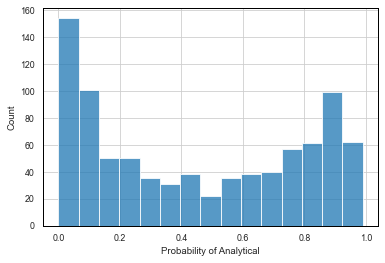

In [ ]:
plt.figure(figsize=(6,4))
sns.set_style("whitegrid", {'axes.linewidth': 2, 'axes.edgecolor':'black'})

sns.set_context("paper")
sns.histplot(z,kde=False,bins=15)

this figure igure shows probability distribution of model over whole dataset, as we see distribution of probabilities are not highly concentrated around border threshold which is 0.5 in this case, and reflecting the fact that model is strong in prediction.